In [1]:
import setuptools
%load_ext Cython

In [2]:
%%cython -a
import cython
cimport cython
import numpy as np
cimport numpy as np
import pandas as pd

In [3]:
import gc
gc.enable()

## 1. Get the Data 

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [5]:
train[:5]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000
1,30,7,Friday,60538815980,1,SHOES,8931
2,30,7,Friday,7410811099,1,PERSONAL CARE,4504
3,26,8,Friday,2238403510,2,PAINT AND ACCESSORIES,3565
4,26,8,Friday,2006613744,2,PAINT AND ACCESSORIES,1017


In [6]:
train.dtypes

TripType                   int64
VisitNumber                int64
Weekday                   object
Upc                      float64
ScanCount                  int64
DepartmentDescription     object
FinelineNumber           float64
dtype: object

## 2. Feature Engineering

In [7]:
# Replace labels with floats
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()

for c in ['Weekday', 'DepartmentDescription']:
    train[c] = lbl_enc.fit_transform(train[c])
    test[c] = lbl_enc.transform(test[c])
    
train[:3]

C:\Program Files\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
C:\Program Files\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,0,68113152929,-1,21,1000
1,30,7,0,60538815980,1,63,8931
2,30,7,0,7410811099,1,51,4504


In [8]:
train.isnull().sum(axis=0)

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription       0
FinelineNumber           4129
dtype: int64

In [9]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='mean')
train = pd.DataFrame(imputer.fit_transform(train), columns=train.columns)
test = pd.DataFrame(imputer.fit_transform(test), columns=test.columns)

In [10]:
train = train.astype(int)
test = test.astype(int)

In [11]:
train.dtypes

TripType                 int32
VisitNumber              int32
Weekday                  int32
Upc                      int32
ScanCount                int32
DepartmentDescription    int32
FinelineNumber           int32
dtype: object

In [12]:
%%time
train_builded = pd.get_dummies(train, columns=['DepartmentDescription', 'FinelineNumber'], prefix=['Department', 'Fineline'], sparse=True)
test_builded = pd.get_dummies(test, columns=['DepartmentDescription', 'FinelineNumber'], prefix=['Department', 'Fineline'], sparse=True)

Wall time: 2min 22s


In [13]:
%%time
train_builded.fillna(0, inplace=True)
test_builded.fillna(0, inplace=True)

Wall time: 37.5 s


In [14]:
cols_tr = list(train_builded.columns)
cols_te = list(test_builded.columns)
cols_tr.remove('Upc')
cols_te.remove('Upc')

train_builded = train_builded[cols_tr]
test_builded = test_builded[cols_te]

In [15]:
train_builded.columns

Index([u'TripType', u'VisitNumber', u'Weekday', u'ScanCount', u'Department_0',
       u'Department_1', u'Department_2', u'Department_3', u'Department_4',
       u'Department_5',
       ...
       u'Fineline_9964', u'Fineline_9966', u'Fineline_9967', u'Fineline_9970',
       u'Fineline_9971', u'Fineline_9974', u'Fineline_9975', u'Fineline_9991',
       u'Fineline_9997', u'Fineline_9998'],
      dtype='object', length=5268)

In [16]:
for col in cols_tr:
    if col not in cols_te:
        test_builded[col] = 0
        cols_te.append(col)

In [17]:
for col in cols_te:
    if col not in cols_tr:
        train_builded[col] = 0
        cols_tr.append(col)

In [18]:
print len(cols_tr)
print len(cols_te)

5426
5426


In [19]:
%%time
train_builded = train_builded.reindex_axis(sorted(cols_tr), axis=1)
test_builded = test_builded.reindex_axis(sorted(cols_tr), axis=1)

Wall time: 924 ms


#### Make grouped data 

In [20]:
def build_part(data, isfinal):
    grouped_part = pd.DataFrame(columns=list(data.columns)[1:])
    rows = data.iloc[0][1:].copy()
    rows = 0
    j = data.iloc[0]['VisitNumber']
    index_end = len(data)
#     print data.index[0]
#     print len(data)

    for i, row in data.iterrows():
        if (row['VisitNumber'] == j):
            rows += row[1:]
        else: 
            grouped_part.loc[len(grouped_part)] = rows
            rows = row[1:]
            j = row['VisitNumber']
            if(not isfinal and i - data.index[0] > len(data) - 100):
                    index_end = i
                    break
        if(isfinal and i == data.index[len(data)-1]):
            grouped_part.loc[len(grouped_part)] = rows
    return grouped_part, index_end

def build_grouped(data):
    print 'build data with numbers (' + str(data.ix[0].VisitNumber) + ',' + str(data.ix[len(data)-1].VisitNumber) + ')'
        
    grouped = pd.DataFrame(columns=data.columns[1:])
    start = 0
    for k in range(50):
        end = len(data) if k == 49 else (k + 1) * (len(data) / 50)
#         print k, start, end
        part = data[start:end]
        
        grouped_part, start = build_part(part, k == 49)
        grouped = grouped.append(grouped_part)
    
    return grouped

##### Train 

In [21]:
cols = list(train_builded.columns)
num_cols = ['VisitNumber', 'TripType', 'Weekday', 'ScanCount']
[cols.remove(c) for c in num_cols]
train_numbers = train_builded[num_cols].groupby(['VisitNumber', 'Weekday', 'TripType'], as_index=False).sum()
grouped_cols = ['VisitNumber'] + cols

In [22]:
%%time
tr_b_1 = train_builded[grouped_cols][:99981].reset_index(drop=True)
tr_b_2 = train_builded[grouped_cols][99981:199999].reset_index(drop=True)
tr_b_3 = train_builded[grouped_cols][199999:299979].reset_index(drop=True)
tr_b_4 = train_builded[grouped_cols][299979:399991].reset_index(drop=True)
tr_b_5 = train_builded[grouped_cols][399991:499994].reset_index(drop=True)
tr_b_6 = train_builded[grouped_cols][499994:599991].reset_index(drop=True)
tr_b_7 = train_builded[grouped_cols][599991:].reset_index(drop=True)

Wall time: 1min 24s


In [23]:
%%time
tr_g_1 = build_grouped(tr_b_1).to_sparse()
tr_g_2 = build_grouped(tr_b_2).to_sparse()
tr_g_3 = build_grouped(tr_b_3).to_sparse()
tr_g_4 = build_grouped(tr_b_4).to_sparse()
tr_g_5 = build_grouped(tr_b_5).to_sparse()
tr_g_6 = build_grouped(tr_b_6).to_sparse()
tr_g_7 = build_grouped(tr_b_7).to_sparse()

build data with numbers (5,28987)
build data with numbers (28988,59429)
build data with numbers (59431,90437)
build data with numbers (90438,118089)
build data with numbers (118090,148190)
build data with numbers (148192,179080)
build data with numbers (179081,191347)
Wall time: 41min 55s


In [24]:
%%time
result = tr_g_1.append(tr_g_2)
result = result.append(tr_g_3)
result = result.append(tr_g_4)
result = result.append(tr_g_5)
result = result.append(tr_g_6)
result = result.append(tr_g_7)

Wall time: 3min 9s


In [25]:
# pd.concat([train_numbers, grouped], axis=1, join='inner')
train_grouped = result.reset_index(drop=True)
# train_grouped['TripType'] = train_triptype

In [35]:
%%time
train_grouped = pd.concat([train_numbers, train_grouped], axis=1)

Wall time: 14min 42s


##### Test 

In [26]:
cols = list(test_builded.columns)
num_cols = ['VisitNumber', 'TripType', 'Weekday', 'ScanCount']
[cols.remove(c) for c in num_cols]
test_numbers = test_builded[num_cols].groupby(['VisitNumber', 'Weekday', 'TripType'], as_index=False).sum()
grouped_cols = ['VisitNumber'] + cols

In [27]:
%%time
te_b_1 = test_builded[grouped_cols][:99998].reset_index(drop=True)
te_b_2 = test_builded[grouped_cols][99998:199996].reset_index(drop=True)
te_b_3 = test_builded[grouped_cols][199996:299950].reset_index(drop=True)
te_b_4 = test_builded[grouped_cols][299950:388934].reset_index(drop=True)
te_b_5 = test_builded[grouped_cols][388934:478991].reset_index(drop=True)
te_b_6 = test_builded[grouped_cols][478991:569982].reset_index(drop=True)
te_b_7 = test_builded[grouped_cols][569982:].reset_index(drop=True)

Wall time: 3min 32s
Parser   : 291 ms


In [28]:
%%time
te_g_1 = build_grouped(te_b_1).to_sparse()
te_g_2 = build_grouped(te_b_2).to_sparse()
te_g_3 = build_grouped(te_b_3).to_sparse()
te_g_4 = build_grouped(te_b_4).to_sparse()
te_g_5 = build_grouped(te_b_5).to_sparse()
te_g_6 = build_grouped(te_b_6).to_sparse()
te_g_7 = build_grouped(te_b_7).to_sparse()

build data with numbers (1,29352)
build data with numbers (29353,59894)
build data with numbers (59895,90831)
build data with numbers (90832,114963)
build data with numbers (114965,142337)
build data with numbers (142338,168446)
build data with numbers (168447,191348)
Wall time: 55min 37s


In [29]:
%%time
result = te_g_1.append(te_g_2)
result = result.append(te_g_3)
result = result.append(te_g_4)
result = result.append(te_g_5)
result = result.append(te_g_6)
result = result.append(te_g_7)

Wall time: 10min 26s


In [30]:
test_grouped = result.reset_index(drop=True)

In [33]:
%%time
test_grouped = pd.concat([test_numbers, test_grouped], axis=1)

Wall time: 5min 23s


In [34]:
test_grouped[:3]

,VisitNumber,Weekday,TripType,ScanCount,Department_0,Department_1,Department_10,Department_11,Department_12,Department_13,...,Fineline_9969,Fineline_9970,Fineline_9971,Fineline_9974,Fineline_9975,Fineline_998,Fineline_9991,Fineline_9997,Fineline_9998,Fineline_9999
0,1,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Diagrams and Historgams 

In [132]:
import pylab as pl
import matplotlib as mpl
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


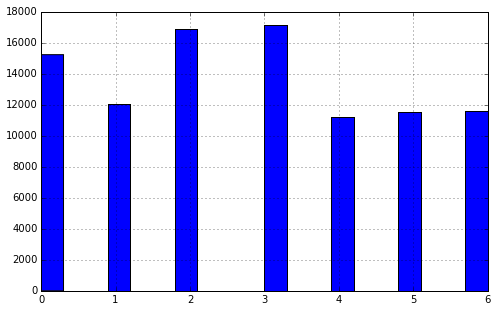

In [137]:
train_grouped['Weekday'].hist(figsize=(8,5), bins=20)

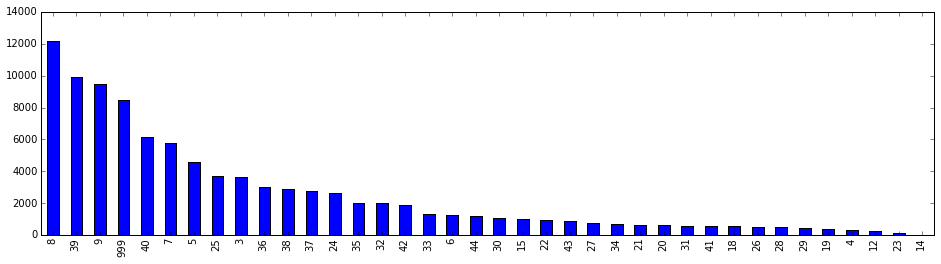

In [141]:
pd.value_counts(train_grouped['TripType']).plot(kind='bar', logy=False, figsize=(16,4))

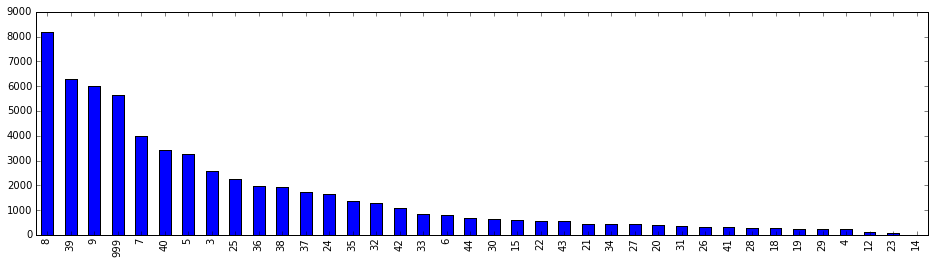

In [152]:
pd.value_counts(train_grouped.loc[(train_grouped['Weekday'] != 2) & (train_grouped['Weekday'] != 3), 'TripType']).plot(kind='bar', logy=False, figsize=(16,4))

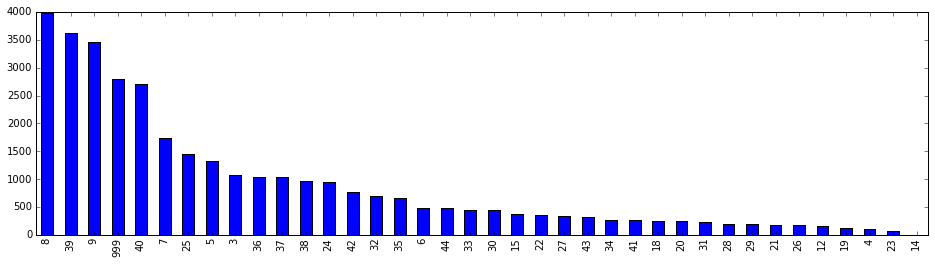

In [151]:
pd.value_counts(train_grouped.loc[(train_grouped['Weekday'] == 2) | (train_grouped['Weekday'] == 3), 'TripType']).plot(kind='bar', logy=False, figsize=(16,4))

##### Add features 

In [160]:
train_grouped['Sat'] = train_grouped['Weekday'].apply(lambda x: int(x == 2))
train_grouped['Sun'] = train_grouped['Weekday'].apply(lambda x: int(x == 3))
train_grouped['Fri'] = train_grouped['Weekday'].apply(lambda x: int(x == 0))
train_grouped['WE'] = train_grouped['Weekday'].apply(lambda x: int(x == 2 or x == 3))

In [203]:
test_grouped['Sat'] = test_grouped['Weekday'].apply(lambda x: int(x == 2))
test_grouped['Sun'] = test_grouped['Weekday'].apply(lambda x: int(x == 3))
test_grouped['Fri'] = test_grouped['Weekday'].apply(lambda x: int(x == 0))
test_grouped['WE'] = test_grouped['Weekday'].apply(lambda x: int(x == 2 or x == 3))

## 3. Cross Validation 

In [161]:
x_columns = list(train_grouped.columns)
x_columns.remove('VisitNumber')
x_columns.remove('TripType')

In [162]:
xtrain = pd.DataFrame(train_grouped[x_columns])
ytrain = train_grouped.TripType

In [114]:
xtrain.columns

Index([u'Weekday', u'ScanCount', u'Department_0', u'Department_1',
       u'Department_10', u'Department_11', u'Department_12', u'Department_13',
       u'Department_14', u'Department_15',
       ...
       u'Fineline_9969', u'Fineline_9970', u'Fineline_9971', u'Fineline_9974',
       u'Fineline_9975', u'Fineline_998', u'Fineline_9991', u'Fineline_9997',
       u'Fineline_9998', u'Fineline_9999'],
      dtype='object', length=5424)

In [204]:
xtest = pd.DataFrame(test_grouped[x_columns])

In [52]:
def multiclass_log_loss(y_true, y_pred, eps=1e-15):
    classes = np.sort(train.TripType.unique())
    Y_true = y_true.apply(lambda x: np.where(classes==x)[0][0]).values
    predictions = np.clip(y_pred, eps, 1 - eps)

    # normalize row sums to 1
    predictions /= predictions.sum(axis=1)[:, np.newaxis]

    actual = np.zeros(y_pred.shape)
    rows = actual.shape[0]
    actual[np.arange(rows), Y_true.astype(int)] = 1
    vsota = np.sum(actual * np.log(predictions))
    return -1.0 / rows * vsota

In [165]:
%%time
from sklearn.cross_validation import train_test_split

xtr, xcv, ytr, ycv = train_test_split(xtrain, ytrain, test_size = 0.052,  random_state = 42)

Wall time: 27min 49s


In [96]:
print xtrain.shape
print ytrain.shape
print xtest.shape

(95674, 5424)
(95674L,)
(95674, 5424)


In [97]:
xtest[:3]

,Weekday,ScanCount,Department_0,Department_1,Department_10,Department_11,Department_12,Department_13,Department_14,Department_15,...,Fineline_9969,Fineline_9970,Fineline_9971,Fineline_9974,Fineline_9975,Fineline_998,Fineline_9991,Fineline_9997,Fineline_9998,Fineline_9999
0,0,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,28,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2. Try XGBoost multiclass (gbtree)

In [198]:
# Set params

params = {"objective": "multi:softprob",
          "booster": "gbtree",
          "eta": 0.02,
          "max_depth": 12,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "num_class": 38,
          "eval_metric": 'mlogloss'
          }
num_trees = 1000
stop = 20

In [188]:
labels = np.sort(ytrain.unique())

In [189]:
ytr_labeled = pd.Series([np.where(labels==x)[0][0] for x in ytr])
ycv_labeled = pd.Series([np.where(labels==x)[0][0] for x in ycv])

In [208]:
import xgboost as xgb

# dtrain = xgb.DMatrix(xtr.values, label=ytr_labeled)
# dvalid = xgb.DMatrix(xcv.values, label=ycv_labeled)
dtrain = xgb.DMatrix(xtrain.values)
# dtest = xgb.DMatrix(xtest.values)

In [199]:
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=stop, verbose_eval=True)

Will train until train error hasn't decreased in 20 rounds.
[0]	eval-mlogloss:3.488945	train-mlogloss:3.484662
[1]	eval-mlogloss:3.369131	train-mlogloss:3.360500
[2]	eval-mlogloss:3.255942	train-mlogloss:3.242238
[3]	eval-mlogloss:3.170419	train-mlogloss:3.152864
[4]	eval-mlogloss:3.077815	train-mlogloss:3.056477
[5]	eval-mlogloss:3.005042	train-mlogloss:2.979444
[6]	eval-mlogloss:2.935909	train-mlogloss:2.906423
[7]	eval-mlogloss:2.868654	train-mlogloss:2.835243
[8]	eval-mlogloss:2.808506	train-mlogloss:2.772138
[9]	eval-mlogloss:2.748658	train-mlogloss:2.708629
[10]	eval-mlogloss:2.692649	train-mlogloss:2.649416
[11]	eval-mlogloss:2.646919	train-mlogloss:2.601028
[12]	eval-mlogloss:2.597900	train-mlogloss:2.549376
[13]	eval-mlogloss:2.550341	train-mlogloss:2.498781
[14]	eval-mlogloss:2.508178	train-mlogloss:2.454217
[15]	eval-mlogloss:2.465040	train-mlogloss:2.408780
[16]	eval-mlogloss:2.424236	train-mlogloss:2.365288
[17]	eval-mlogloss:2.385507	train-mlogloss:2.324095
[18]	eval-mlog

In [212]:
dcv = xgb.DMatrix(xcv.values)
XGB1 = gbm.predict(dcv)
indices = XGB1 < 0
XGB1[indices] = 0

In [213]:
multiclass_log_loss(ycv, XGB1)

0.69595485266898949

**The best score is:** 0.69595485266898949

## 5. Predict classes probabilities

#### With XGBoost

In [209]:
predictionXGB = gbm.predict(dtest)
indices = predictionXGB < 0
predictionXGB[indices] = 0

In [210]:
submit_XGB = predictionXGB

In [211]:
submit_XGB

array([[  7.37983737e-06,   6.94389792e-06,   1.26094703e-04, ...,
          1.58802036e-03,   2.06006749e-04,   5.37835294e-03],
       [  3.45582121e-05,   2.29394027e-05,   4.08935390e-04, ...,
          4.09671385e-03,   1.88955411e-04,   6.78752959e-02],
       [  2.49145302e-07,   2.72946608e-07,   5.71642931e-06, ...,
          2.14878605e-06,   1.15194177e-06,   9.99392867e-01],
       ..., 
       [  1.21116813e-04,   1.70696640e-05,   5.83407644e-04, ...,
          9.40852697e-05,   3.70926646e-05,   1.73864383e-02],
       [  2.51428946e-06,   3.02511671e-06,   3.59836231e-05, ...,
          2.33879196e-03,   5.19332709e-03,   6.63512619e-04],
       [  1.85641761e-06,   7.38846097e-07,   8.72191049e-06, ...,
          2.35601678e-03,   2.62166141e-04,   6.97794429e-04]], dtype=float32)

## 5. Submit probas 

In [214]:
cl_names = ['VisitNumber']
for cls in sorted(train.TripType.unique()):
    cl_names.append('TripType_' + str(int(cls)))

In [215]:
submit = pd.DataFrame(columns=cl_names)
submit['VisitNumber'] = test_grouped['VisitNumber']
submit[cl_names[1:]] = submit_XGB
submit[:5]

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
0,1,7.379837e-06,6.943898e-06,0.000126,0.000037,0.001618,0.006131,0.004998,1.936017e-04,7.448252e-06,...,0.000235,0.000302,0.536530,0.021461,8.031166e-05,0.006177,0.003987,0.001588,2.060067e-04,0.005378
1,2,3.455821e-05,2.293940e-05,0.000409,0.000285,0.013750,0.032932,0.020397,1.036934e-03,3.849402e-05,...,0.001604,0.000405,0.010334,0.109185,1.114849e-04,0.001205,0.006974,0.004097,1.889554e-04,0.067875
2,3,2.491453e-07,2.729466e-07,0.000006,0.000002,0.000056,0.000186,0.000010,9.807013e-07,2.792015e-07,...,0.000255,0.000003,0.000007,0.000008,9.541793e-07,0.000002,0.000006,0.000002,1.151942e-06,0.999393
3,4,2.999164e-05,1.246271e-05,0.000538,0.000230,0.004272,0.054137,0.906834,2.369464e-05,1.988423e-05,...,0.000200,0.000083,0.000485,0.000174,3.156497e-05,0.000063,0.000431,0.000055,2.266396e-05,0.022209
4,6,2.023657e-07,2.096462e-07,0.000003,0.000002,0.000055,0.000029,0.000023,1.059930e-06,2.174183e-07,...,0.000004,0.000002,0.000006,0.000003,6.490095e-07,0.000002,0.000009,0.000002,9.385786e-07,0.999765


In [216]:
submit.to_csv('submit.csv', index=False)